In [1]:
import cv2
from cv2 import destroyAllWindows
import mediapipe as mp
import numpy as np
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

STEP1

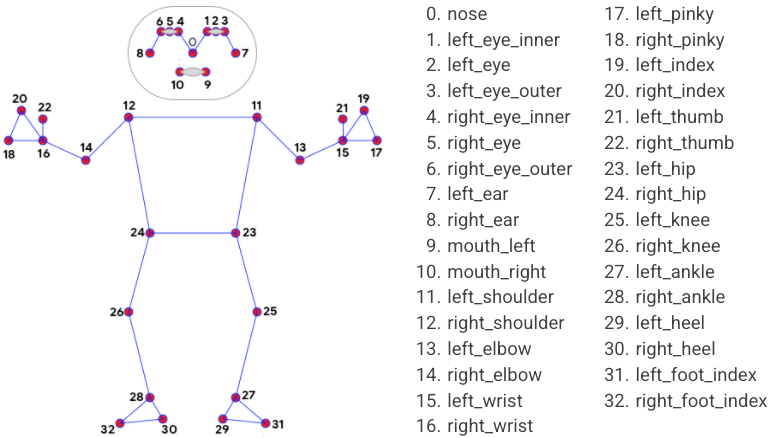

In [2]:
#mp_pose.POSE_CONNECTIONS

In [3]:

def calculate_angle(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0:
        angle = 360-angle
        
    return angle

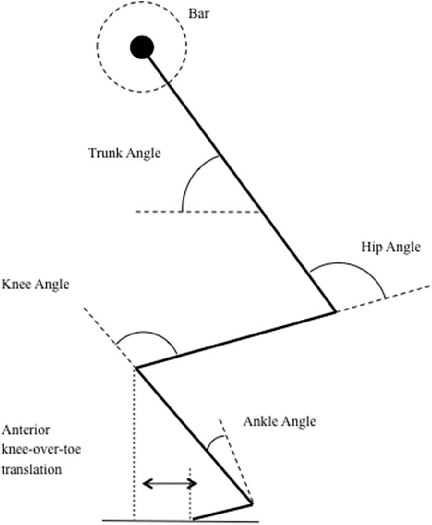

In [50]:
def rescale_frame(frame, percent=75):
    width = int(frame.shape[1] * percent/ 100)
    height = int(frame.shape[0] * percent/ 100)
    dim = (width, height)
    return cv2.resize(frame, dim, interpolation =cv2.INTER_AREA)


In [95]:
# Youtube video
angle_min = []
angle_min_hip = []
cap = cv2.VideoCapture("youTube_video.mp4")



# Curl counter variables
counter = 0 
min_ang = 0
max_ang = 0
min_ang_hip = 0
max_ang_hip = 0
stage = None

width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH) + 0.5)
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT) + 0.5)
size = (640, 480)
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter('output_video_.mp4', fourcc, 24, size)

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        if frame is not None:
            frame_ = rescale_frame(frame, percent=75)
        
        # Recolor image to RGB
        image = cv2.cvtColor(frame_, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
      
        # Make detection
        results = pose.process(image)
    
        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark
            
            # Get coordinates
            shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
            """elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x,landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
            wrist = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x,landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]
            """
            
            # Get coordinates
            hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]
            knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]
            ankle = [landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].y]
            
           
            
            # Calculate angle
            angle = calculate_angle(shoulder, elbow, wrist)
            
            angle_knee = calculate_angle(hip, knee, ankle) #Knee joint angle
            angle_knee = round(angle_knee,2)
            
            angle_hip = calculate_angle(shoulder, hip, knee)
            angle_hip = round(angle_hip,2)
            
            hip_angle = 180-angle_hip
            knee_angle = 180-angle_knee
            
            
            angle_min.append(angle_knee)
            angle_min_hip.append(angle_hip)
            
            #print(angle_knee)
            # Visualize angle
            """cv2.putText(image, str(angle), 
                           tuple(np.multiply(elbow, [640, 480]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                                )"""
                       
                
            cv2.putText(image, str(angle_knee), 
                           tuple(np.multiply(knee, [1500, 800]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2, cv2.LINE_AA
                                )
            
            cv2.putText(image, str(angle_hip), 
                           tuple(np.multiply(hip, [1500, 800]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                                )
            
            # Curl counter logic
            if angle_knee > 169:
                stage = "up"
            if angle_knee <= 90 and stage =='up':
                stage="down"
                counter +=1
                print(counter)
                min_ang  =min(angle_min)
                max_ang = max(angle_min)
                
                min_ang_hip  =min(angle_min_hip)
                max_ang_hip = max(angle_min_hip)
                
                print(min(angle_min), " _ ", max(angle_min))
                print(min(angle_min_hip), " _ ", max(angle_min_hip))
                angle_min = []
                angle_min_hip = []
        except:
            pass
        
        # Render squat counter
        # Setup status box
        cv2.rectangle(image, (20,20), (435,160), (0,0,0), -1)
        
        # Rep data
        """cv2.putText(image, 'REPS', (15,12), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)"""
        cv2.putText(image, "Repetition : " + str(counter), 
                    (30,60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
        # Stage data
        """cv2.putText(image, 'STAGE', (65,12), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)"""
        """cv2.putText(image, stage, 
                    (10,120), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)"""
        
        #Knee angle:
        """cv2.putText(image, 'Angle', (65,12), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)"""
        cv2.putText(image, "Knee-joint angle : " + str(min_ang), 
                    (30,100), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
        #Hip angle:
        cv2.putText(image, "Hip-joint angle : " + str(min_ang_hip), 
                    (30,140), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        

        
        
        # Render detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(0,0,0), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(203,17,17), thickness=2, circle_radius=2) 
                                 )               
        
        out.write(image)
        cv2.imshow('Mediapipe Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            cap.release()
            out.release()
            cv2.destroyAllWindows()
            #break

    cap.release()
    out.release()
    cv2.destroyAllWindows()
    

1
89.78  _  179.99
98.95  _  175.7
2
54.24  _  176.66
61.91  _  170.82
3
49.49  _  176.65
54.59  _  170.06
4
55.56  _  176.57
61.53  _  170.54
5
55.21  _  177.81
63.13  _  172.7


In [49]:
frame_.shape[1]

1440

#### Range of motion
Partial squat (0-40 degrees knee angle)<br>
Parallel squat (hips parallel to knees or 70-100 degrees knee angle)<br>
Deep squat (full range or >100 degrees knee angle)<br><br>

ref: https://www.raynersmale.com/blog/2014/1/31/optimising-your-squat

TODO: Toque calculation:
https://squatuniversity.com/2016/04/20/the-real-science-of-the-squat/

Todo: angles:
Trunk angle,
Shank angle
Thigh segment angle
Ankle segment angle
ref: https://www.quinticsports.com/squatting_technique/

In [31]:
# webcam input

cap = cv2.VideoCapture(0)
# Curl counter variables
counter = 0 
stage = None

"""width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH) + 0.5)
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT) + 0.5)
size = (width, height)
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter('your_video.mp4', fourcc, 10.0, size, True)"""

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        
        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
      
        # Make detection
        results = pose.process(image)
    
        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark
            
            # Get coordinates
            shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
            elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x,landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
            wrist = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x,landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]
            
            
            # Get coordinates
            hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x,landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
            knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x,landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
            ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x,landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y]
            
           
            
            # Calculate angle
            angle = calculate_angle(shoulder, elbow, wrist)
            
            angle_knee = calculate_angle(hip, knee, ankle) #Knee joint angle
            
            angle_hip = calculate_angle(shoulder, hip, knee)
            hip_angle = 180-angle_hip
            knee_angle = 180-angle_knee
            
            # Visualize angle
            """cv2.putText(image, str(angle), 
                           tuple(np.multiply(elbow, [640, 480]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                                )"""
                       
                
            cv2.putText(image, str(angle_knee), 
                           tuple(np.multiply(knee, [640, 480]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (79, 121, 66), 2, cv2.LINE_AA
                                )
            
            """cv2.putText(image, str(angle_hip), 
                           tuple(np.multiply(hip, [640, 480]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                                )"""
            
            # Curl counter logic
            if angle_knee > 169:
                stage = "UP"
            if angle_knee <= 90 and stage =='UP':
                stage="DOWN"
                counter +=1
                print(counter)
        except:
            pass
        
        # Render squat counter
        # Setup status box
        cv2.rectangle(image, (0,0), (225,73), (245,117,16), -1)
        
        # Rep data
        cv2.putText(image, 'REPS', (15,12), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, str(counter), 
                    (10,60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)
        
        # Stage data
        cv2.putText(image, 'STAGE', (65,12), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, stage, 
                    (60,60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)
        
        
        # Render detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                 )               
        
        out.write(image)
        cv2.imshow('Mediapipe Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    #out.release()
    cv2.destroyAllWindows()
    
#destroyAllWindows()



1
2
3
4
5
6
7
8
9
10


In [16]:
len(landmarks)

33

In [4]:
for lnmark in mp_pose.PoseLandmark:
    print(lnmark)

PoseLandmark.NOSE
PoseLandmark.LEFT_EYE_INNER
PoseLandmark.LEFT_EYE
PoseLandmark.LEFT_EYE_OUTER
PoseLandmark.RIGHT_EYE_INNER
PoseLandmark.RIGHT_EYE
PoseLandmark.RIGHT_EYE_OUTER
PoseLandmark.LEFT_EAR
PoseLandmark.RIGHT_EAR
PoseLandmark.MOUTH_LEFT
PoseLandmark.MOUTH_RIGHT
PoseLandmark.LEFT_SHOULDER
PoseLandmark.RIGHT_SHOULDER
PoseLandmark.LEFT_ELBOW
PoseLandmark.RIGHT_ELBOW
PoseLandmark.LEFT_WRIST
PoseLandmark.RIGHT_WRIST
PoseLandmark.LEFT_PINKY
PoseLandmark.RIGHT_PINKY
PoseLandmark.LEFT_INDEX
PoseLandmark.RIGHT_INDEX
PoseLandmark.LEFT_THUMB
PoseLandmark.RIGHT_THUMB
PoseLandmark.LEFT_HIP
PoseLandmark.RIGHT_HIP
PoseLandmark.LEFT_KNEE
PoseLandmark.RIGHT_KNEE
PoseLandmark.LEFT_ANKLE
PoseLandmark.RIGHT_ANKLE
PoseLandmark.LEFT_HEEL
PoseLandmark.RIGHT_HEEL
PoseLandmark.LEFT_FOOT_INDEX
PoseLandmark.RIGHT_FOOT_INDEX


In [6]:
"""#dash app for pose detection: live video
#import sys
import dash
import asyncio
import dash_core_components as dcc
import dash_html_components as html

from flask import Flask, Response
import cv2

class VideoCamera(object):
    def __init__(self):
        self.video = cv2.VideoCapture("youTube_video.mp4")

    def __del__(self):
        self.video.release()
        destroyAllWindows()

    def get_frame(self):
        """"""with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
            success, image = self.video.read()

            # Recolor image to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False

            # Make detection
            results = pose.process(image)

            # Recolor back to BGR
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            # Render detections
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                      mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
                                      mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2)
                                      )""""""
        success, image = self.video.read()
        _, jpeg = cv2.imencode('.jpg', image)
        return jpeg.tobytes()




def gen(camera):
    
    while True:
        #if sys.platform == "win32" and (3, 8, 0) <= sys.version_info < (3, 9, 0):asyncio.set_event_loop_policy(asyncio.WindowsSelectorEventLoopPolicy())
        
        frame = camera.get_frame()
        
        yield (b'--frame\r\n'
               b'Content-Type: image/jpeg\r\n\r\n' + frame + b'\r\n\r\n')

server = Flask(__name__)
app = dash.Dash(__name__, server=server)

@server.route('/video_feed')
def video_feed():
    return Response(gen(VideoCamera()),
                    mimetype='multipart/x-mixed-replace; boundary=frame')

app.layout = html.Div([
    html.H1("Webcam Test"),
    html.Img(style={'width': '30%', 'padding': 10},src="/video_feed")
])

if __name__ == '__main__':
    app.run_server(debug=False)"""

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [29/Sep/2021 23:06:56] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [29/Sep/2021 23:06:56] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [29/Sep/2021 23:06:56] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [29/Sep/2021 23:06:56] "GET /video_feed HTTP/1.1" 200 -
Error on request:
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\Lib\site-packages\werkzeug\serving.py", line 319, in run_wsgi
    execute(self.server.app)
  File "C:\Users\Admin\anaconda3\Lib\site-packages\werkzeug\serving.py", line 310, in execute
    for data in application_iter:
  File "C:\Users\Admin\anaconda3\Lib\site-packages\werkzeug\wsgi.py", line 462, in __next__
    return self._next()
  File "C:\Users\Admin\anaconda3\Lib\site-packages\werkzeug\wrappers\response.py", line 49, in _iter_encoded
    for item in iterable:
  File "<ipython-input-6-40b1029506a2>", line 51, in gen
    
  File "<ipython-input-6-40b1029506a2>", l

In [ ]:
"""#dash app for youtube video
#import sys
import dash
import asyncio
import dash_core_components as dcc
import dash_html_components as html

from flask import Flask, Response
import cv2

class VideoCamera(object):
    def __init__(self):
        self.video = cv2.VideoCapture("youTube_video.mp4")

    def __del__(self):
        self.video.release()
        destroyAllWindows()

    def get_frame(self):
        """"""with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
            success, image = self.video.read()

            # Recolor image to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False

            # Make detection
            results = pose.process(image)

            # Recolor back to BGR
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            # Render detections
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                      mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
                                      mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2)
                                      )""""""
        success, image = self.video.read()
        _, jpeg = cv2.imencode('.jpg', image)
        return jpeg.tobytes()




def gen(camera):
    
    while True:
        #if sys.platform == "win32" and (3, 8, 0) <= sys.version_info < (3, 9, 0):asyncio.set_event_loop_policy(asyncio.WindowsSelectorEventLoopPolicy())
        
        frame = camera.get_frame()
        
        yield (b'--frame\r\n'
               b'Content-Type: image/jpeg\r\n\r\n' + frame + b'\r\n\r\n')

server = Flask(__name__)
app = dash.Dash(__name__, server=server)

@server.route('/video_feed')
def video_feed():
    return Response(gen(VideoCamera()),
                    mimetype='multipart/x-mixed-replace; boundary=frame')

app.layout = html.Div([
    html.H1("Webcam Test"),
    html.Img(style={'width': '30%', 'padding': 10},src="/video_feed")
])

if __name__ == '__main__':
    app.run_server(debug=False)"""